In [2]:
# If you'd like to install packages that aren't installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere

#import sys
#!{sys.executable} -m pip install <package list>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as CtgEncoders

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from lightgbm import LGBMClassifier

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot

from sklearn.metrics import classification_report, confusion_matrix, f1_score

from warnings import filterwarnings

pd.set_option('display.float_format', lambda num:'%1.3f'%num)
pd.set_option('display.max_columns', 99)
filterwarnings('ignore')

plt.style.use('ggplot')

# Data Description

Feature | Description
:---|:---
UniqueId |The unique id of an invoice.
Region |The geographical region of the customer.
OrderDate| The date on which order is placed. (YYYY-MM-DD)
InvoiceDate| The date on which the invoice is generated. (YYYY-MM-DD)
Amount| The amount of the invoice. (in the US $$)
DueDate| Due date by which payment should have been done.
Dispute| Whether the customer has accepted or not the invoice amount. False indicates the invoice is accepted while  True indicates a  disagreement.
InvoiceType| The invoice can be of two types, ‘electronic’ or ‘paper’.
Delay|This is the response variable. True to indicate that the payment deadline was violated and False to indicate on-time clearance.

# Data Wrangling & Visualizations

### 1. Load Data - Data Types

In [4]:
train = pd.read_csv('train.csv', index_col=0)

In [5]:
train.head()

,Region,OrderDate,InvoiceDate,DueDate,Amount,Disputed,InvoiceType,Delay
UniqueId,,,,,,,,
5133177585,North America,2011-11-06,2012-01-03,2012-02-06,55.370,No,Paper,True
280670965,South America,2011-11-17,2012-01-03,2012-02-15,50.390,No,Paper,False
6393629835,Europe,2011-11-28,2012-01-03,2012-02-15,71.330,No,Paper,False
5928070131,Africa&Asia,2011-11-01,2012-01-03,2012-01-22,97.600,No,Paper,True
6050714721,Africa&Asia,2011-11-08,2012-01-03,2012-02-15,15.990,Yes,Paper,True


In [6]:
print("Data shapes: Train->{}".format(train.shape))

Data shapes: Train->(1850, 8)


In [7]:
train.dtypes

Region          object
OrderDate       object
InvoiceDate     object
DueDate         object
Amount         float64
Disputed        object
InvoiceType     object
Delay             bool
dtype: object

### 2. Outlier Detection

In [8]:
#1. Region
train.Region.value_counts()

North America      451
Europe             419
South America      372
Africa&Asia        294
Central America    284
Africa&psia          1
SouthCUmeVica        1
Souty America        1
Name: Region, dtype: int64

In [9]:
region_dict = {'Africa&psia':'Africa&Asia', 'Souty America':'South America', 'SouthCUmeVica':'South America'}

In [10]:
train['Region'] = train.Region.apply(lambda v:region_dict[v] if v in region_dict else v)
train.Region.unique() #check

array(['North America', 'South America', 'Europe', 'Africa&Asia',
       'Central America', nan], dtype=object)

In [11]:
def assert_dates(dates):
    nan =  pd.to_datetime(dates, errors='coerce').isna().sum()
    return "There are {} invalid dates.".format(nan)

In [12]:
#2. OrderDate
print(assert_dates(train.OrderDate))
train.OrderDate.sort_values()

There are 6 invalid dates.


UniqueId
4336863090    1011-12-10
3399547582    1012-09-20
959092964     1012-12-01
8568370573    2011-10-08
8701747713    2011-10-19
                 ...    
7630260848    2013-05-15
951035745     2013-05-25
5370094352    2311-12-09
1767317198    3012-07-25
5016123354    3012-12-02
Name: OrderDate, Length: 1850, dtype: object

In [13]:
train.OrderDate = train.OrderDate.replace(
    ['1011-12-10', '2311-12-09', '3012-07-25', '3012-12-02', '1012-09-20', '1012-12-01'], 
    ['2011-12-10', '2011-12-09', '2012-07-25', '2012-12-02', '2012-09-20', '2012-12-01']).sort_values()
print(assert_dates(train.OrderDate))

There are 0 invalid dates.


In [14]:
#3. InvoiceDate
print(assert_dates(train.InvoiceDate))
train.InvoiceDate.sort_values()

There are 8 invalid dates.


UniqueId
8772170448    1012-05-22
41324194      1012-10-21
9367388295    1013-40-24
6222252019    1912-05-05
5133177585    2012-01-03
                 ...    
9847742890    2213-02-05
2225581009    2413-01-92
387380707     2912-18-40
7976742421    3012-07-06
8131076647    3012-12-08
Name: InvoiceDate, Length: 1850, dtype: object

In [15]:
outliers =  ['2025-21-11', '1912-05-05', '2119-05-02', '1012-05-22', '1012-10-21', '1013-40-24', '2213-02-05', '2413-01-92', '2912-18-40', '3012-07-06', '3012-12-08']
treatment = ['',           '2012-05-05', '',            '2012-05-22', '2012-10-21', '2013-04-24', '2013-02-05', '2013-01-29', '2012-18-04', '2012-07-06', '2012-12-08']
train.InvoiceDate.replace(outliers, treatment, inplace=True)
print(assert_dates(train.InvoiceDate))

There are 3 invalid dates.


In [16]:
train.InvoiceDate.sort_values()

UniqueId
915133709               
2268924543              
6050714721    2012-01-03
5133177585    2012-01-03
6393629835    2012-01-03
                 ...    
951035745     2013-06-05
9018028314    2013-06-05
3924052139    2013-06-05
1858692476    2013-06-05
8473757844    2013-06-05
Name: InvoiceDate, Length: 1850, dtype: object

In [17]:
# 4. DueDate
print(assert_dates(train.DueDate))
train.DueDate.sort_values()

There are 6 invalid dates.


UniqueId
9566049241    1012-10-70
5018112852    1013-02-21
3636727153    1112-04-14
5928070131    2012-01-22
8493182849    2012-01-23
                 ...    
9018028314    2013-07-18
951035745     2013-07-18
7683330179    3012-06-44
8164212163    3013-06-09
9506308848    3013-50-06
Name: DueDate, Length: 1850, dtype: object

In [18]:
outliers =  ['1012-10-70', '1013-02-21', '1112-04-14', '3012-06-44', '3013-06-09', '3013-50-06']
treatment = ['2012-10-07', '2013-02-21', '2012-04-14', '2012-06-14', '2013-06-09', '2013-05-06']
train.DueDate.replace(outliers, treatment, inplace=True)
print(assert_dates(train.DueDate))

There are 0 invalid dates.


In [19]:
train.DueDate.sort_values()

UniqueId
5928070131    2012-01-22
8493182849    2012-01-23
6482427308    2012-01-25
5133177585    2012-02-06
4984149604    2012-02-07
                 ...    
5302225359    2013-07-17
5667168406    2013-07-17
9566496102    2013-07-17
9018028314    2013-07-18
951035745     2013-07-18
Name: DueDate, Length: 1850, dtype: object

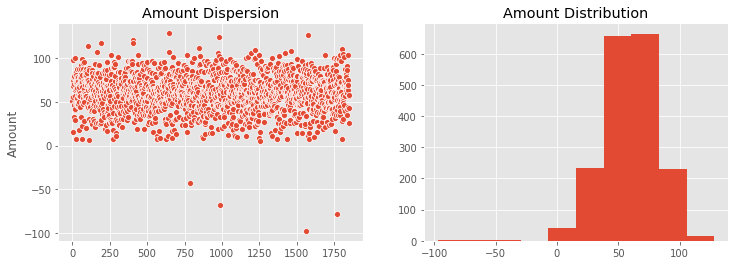

In [20]:
# 5. Amount
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.scatterplot(np.arange(0, len(train)), train.Amount, ax=ax1)
ax2.hist(train.Amount)
ax1.set_title('Amount Dispersion')
ax2.set_title('Amount Distribution');

In [21]:
train.Amount = np.abs(train.Amount.values)

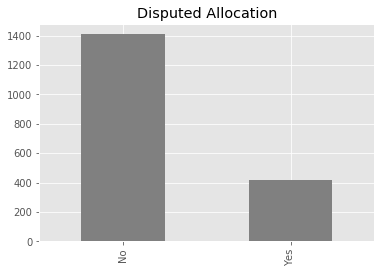

In [22]:
# 6. Disputed
train.Disputed.value_counts().plot(kind='bar', color='grey', title='Disputed Allocation');

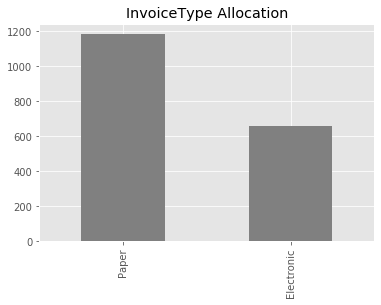

In [23]:
#7. Invoice Type
train.InvoiceType.value_counts().plot(kind='bar', color='grey', title='InvoiceType Allocation');

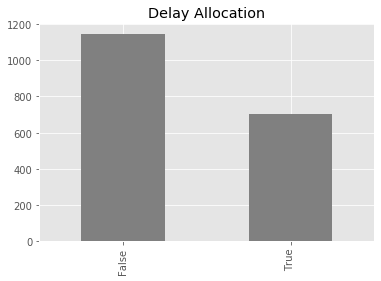

In [24]:
# Delay
train.Delay.value_counts().plot(kind='bar', color='grey', title='Delay Allocation');

**Train Outlier Treatment Report**
- Discovered Outliers were corrected to the most probable values. If it could not be an inference then they were replaced so as to be removed in the Handling Missing Values process. The results were:

1. minimized invalid number of dates
2. negative Amount was turned to positive. 

### 3. Handling Missing Values 

In [25]:
train.isna().sum()

Region         27
OrderDate       0
InvoiceDate     0
DueDate         0
Amount          8
Disputed       27
InvoiceType     8
Delay           0
dtype: int64

In [26]:
train.Amount.fillna(train.Amount.mean(), inplace=True)
train.fillna('Unknown', inplace=True)

In [27]:
print("Train NaNs:", train.isna().sum().sum())

Train NaNs: 0


**Train NaN Report**
- Missing values of Amount feature were replaced with the mean while the categorical variables had the missing values replaced with another catergory; the 'Unknown'

### 3. Transform Data Types

In [28]:
tsvars = """OrderDate InvoiceDate DueDate""".split()
train[tsvars] = train[tsvars].apply(pd.to_datetime, errors='coerce')
train.dropna(inplace=True) #drop rows containing invalid dates if any
ctgs = "Region Disputed InvoiceType".split()
train[ctgs] = train[ctgs].astype('category')
train.dtypes

Region               category
OrderDate      datetime64[ns]
InvoiceDate    datetime64[ns]
DueDate        datetime64[ns]
Amount                float64
Disputed             category
InvoiceType          category
Delay                    bool
dtype: object

In [29]:
print('Train Set Shape:', train.shape)

Train Set Shape: (1847, 8)


### 5. Exploratory Data Analysis

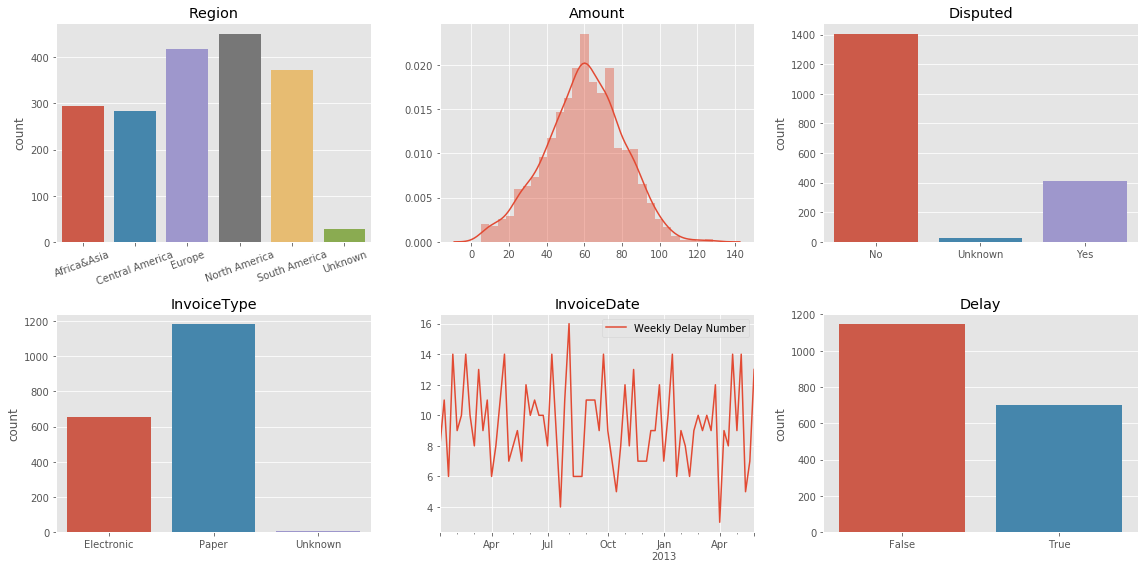

In [30]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 8))
sns.countplot(train.Region, ax=ax1)
ax1.set_xticklabels(labels=ax1.get_xticklabels(), rotation=20)
sns.distplot(train['Amount'], ax=ax2)
sns.countplot(train.Disputed, ax=ax3)
sns.countplot(train.InvoiceType, ax=ax4)
sns.countplot(train.Delay, ax=ax6)
train[['InvoiceDate', 'Delay']].set_index('InvoiceDate', drop=True).resample('W').sum()[:-1].plot(ax=ax5)#droplastone
for ax in (ax1, ax2,ax3,ax4,ax5,ax6): 
    ax.set_title(ax.get_xlabel())
    ax.set_xlabel(None)
ax5.legend(["Weekly Delay Number"])
plt.tight_layout()

**Report**
- Europe and North America are the most important regions
- Disputed invoice are about 3 and 1/2 times less than non-disputed ones.
- Amounts seems to be normally distributed.
- Paper invoices are double in number in comparison with electronic ones.

- Number of delays in invoice payment seems to have a slight negative trend.

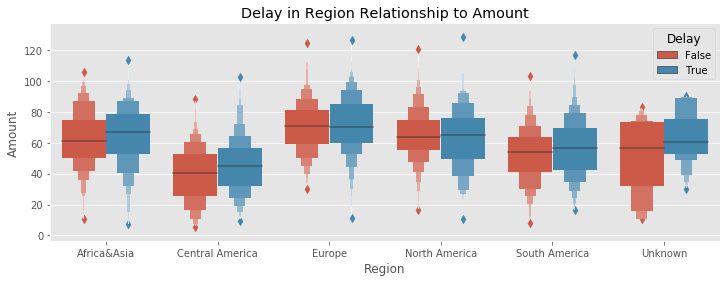

In [31]:
plt.figure(figsize=(12,4))
sns.boxenplot('Region', 'Amount', hue='Delay', data=train)
plt.title("Delay in Region Relationship to Amount");

- There seems a connection of high amounts to Delay for all regions besides Europe where the opposite happens.

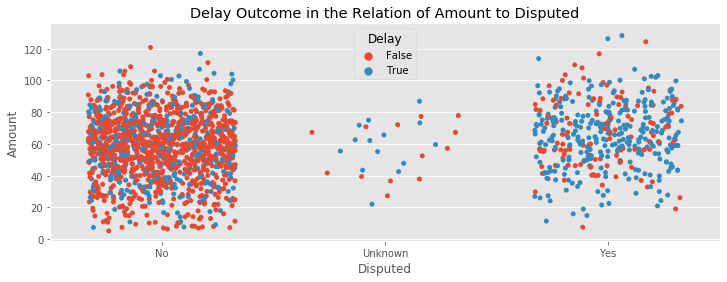

In [32]:
plt.figure(figsize=(12,4))
sns.stripplot("Disputed", "Amount", hue='Delay', data=train, jitter=0.33)
plt.title("Delay Outcome in the Relation of Amount to Disputed");

- Disputed invoices are more probable to be delayed. 
- There is not a clear connection of Amount to Delay when invoice is or is not disputed.

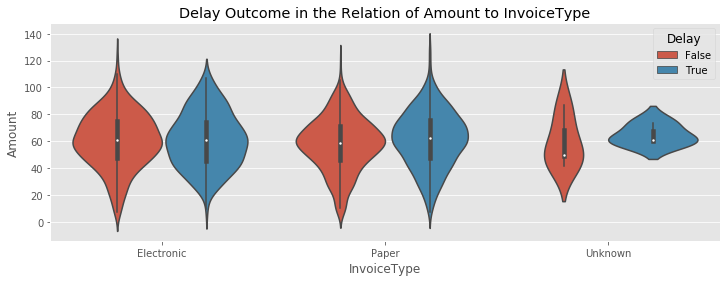

In [33]:
plt.figure(figsize=(12,4))
sns.violinplot("InvoiceType", "Amount", hue='Delay', data=train, )
plt.title("Delay Outcome in the Relation of Amount to InvoiceType");

- High amounts of paper invoices seem more connected to Delay occurences.

In [34]:
ordertsa = train[['OrderDate', 'Delay']].set_index('OrderDate', drop=True).resample('W').sum()
invoicetsa = train[['InvoiceDate', 'Delay']].set_index('InvoiceDate', drop=True).resample('W').sum()
duetsa = train[['DueDate', 'Delay']].set_index('DueDate', drop=True).resample('W').sum()

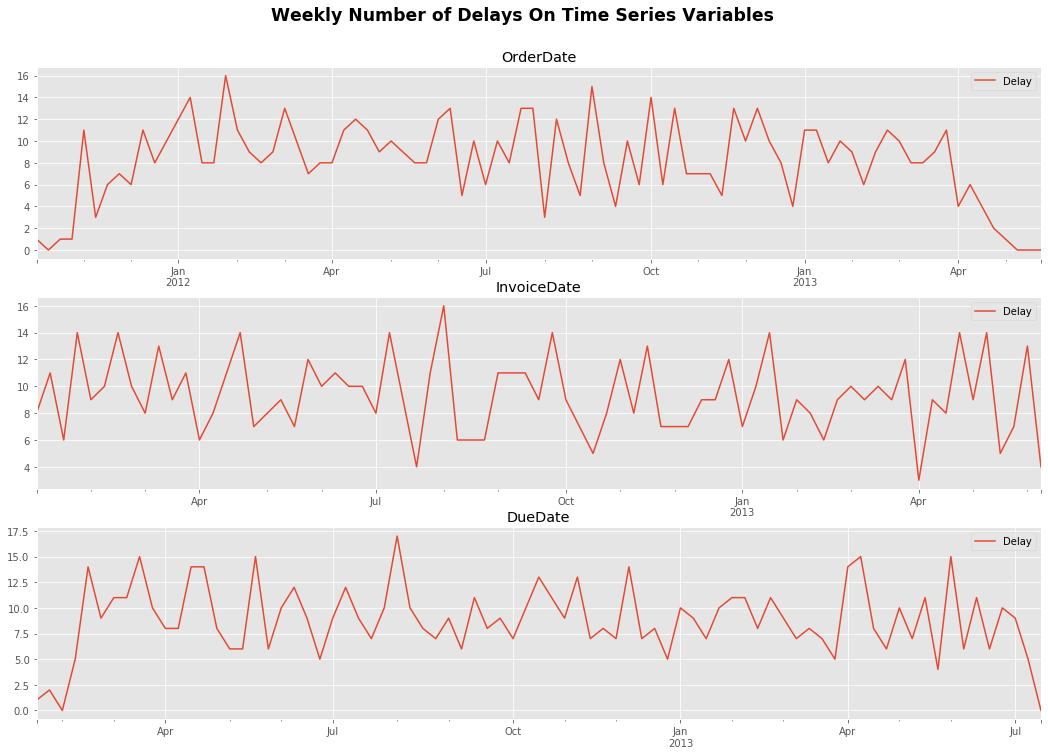

In [35]:
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(18, 12))
for ax,series, name in [(ax1,ordertsa, 'OrderDate'), (ax2,invoicetsa, 'InvoiceDate'), (ax3,duetsa, 'DueDate')]:
    series.plot(kind='line', ax=ax)
    ax.set_title(name)
    ax.set_xlabel("")
plt.suptitle("Weekly Number of Delays On Time Series Variables", y=0.95, fontsize='xx-large', fontweight='bold' );

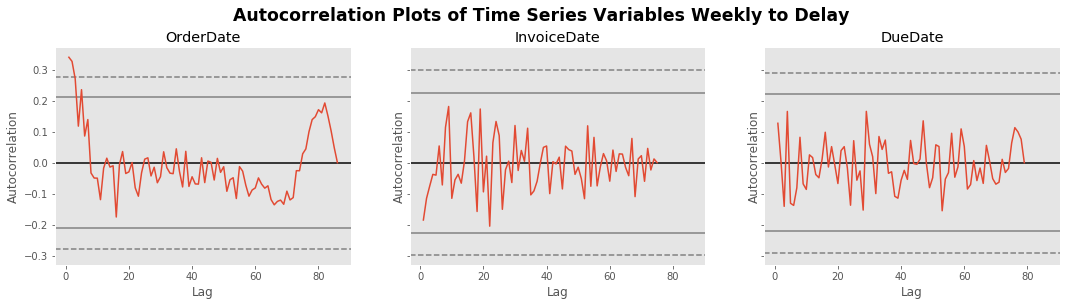

In [36]:
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
for ax,series, name in [(ax1,ordertsa, 'OrderDate'), (ax2,invoicetsa, 'InvoiceDate'), (ax3,duetsa, 'DueDate')]:
    autocorrelation_plot(series, ax=ax)
    ax.set_title("{}".format(name))
plt.suptitle("Autocorrelation Plots of Time Series Variables Weekly to Delay", y=1.02, fontsize='xx-large', fontweight='bold');

- The order date seems to have a limited but significant autocorrelation to the weekly number of delays.

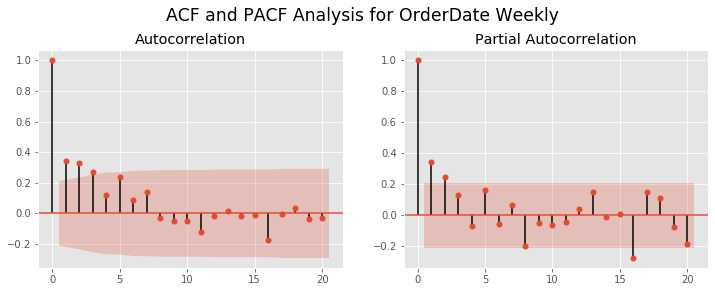

In [37]:
f, (ax2, ax1) = plt.subplots(1,2, figsize=(12, 4))
pacf, acf = plot_pacf(ordertsa, ax=ax1), plot_acf(ordertsa, ax=ax2)
plt.suptitle("ACF and PACF Analysis for OrderDate Weekly", fontsize='xx-large', y=1.03);

- The autocorrelation weeks are 3 and the partial autocorrelation weeks are two. This means that there seem to be a predictability of the delay numbers of next week from the previous 3 ones.

In [38]:
# Stationarity Test for OrderDate
adf_test, pvalue, _, _, crtl, _ = adfuller(ordertsa.squeeze()[:-1]) # drop last week in case of missing data
print("ADF Test: {:1.3}\nP-Value: {:1.3f}\n\nCritical Values\n{}".format(adf_test, pvalue, pd.Series(crtl)))

ADF Test: -3.1
P-Value: 0.026

Critical Values
1%    -3.513
5%    -2.897
10%   -2.586
dtype: float64


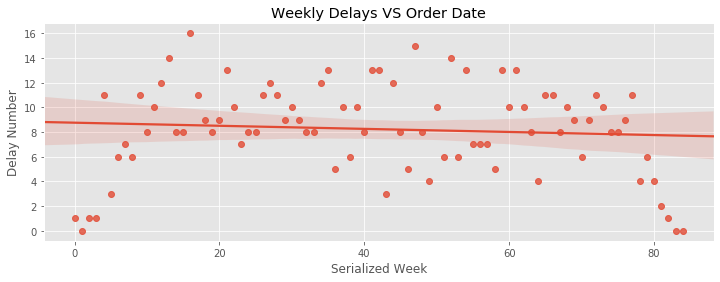

In [39]:
# Regression Plot for Order Date
x = np.arange(ordertsa[:-1].shape[0])
plt.figure(figsize=(12,4))
sns.regplot(x, ordertsa.squeeze()[:-1].values)
plt.title("Weekly Delays VS Order Date")
plt.ylabel("Delay Number")
plt.xlabel("Serialized Week");

- There seems to be a slight negative trend on the weekly time series but according to the stationarity test we may consider the weekly time series stationary with a confidence of 95%

#### Weekly Summary per Region

In [40]:
sumdata = train.set_index('InvoiceDate', drop=True).drop(columns=['OrderDate', 'DueDate', 'InvoiceType'])
sumdata['IsPaper'] = (train.InvoiceType=='Paper').values
sumdata['DueDays'] = pd.Series(train.DueDate.values - train.InvoiceDate.values, index=sumdata.index).astype(str).str.split().apply(lambda li:int(li[0]))

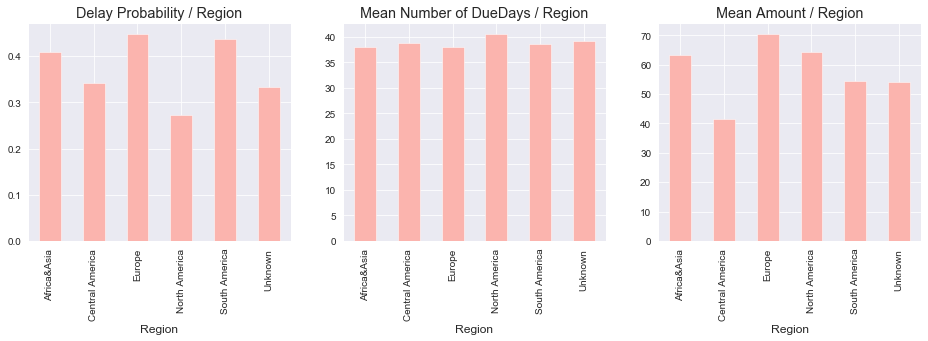

In [41]:
sns.set_style('darkgrid')
sns.set_palette('Pastel1')
region_summary = sumdata.groupby('Region').agg({'DueDays':'mean', 'Delay':'mean', 'Amount':'mean'})
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,4))
region_summary['Delay'].plot(kind='bar', title='Delay Probability / Region', ax=ax1)
region_summary['DueDays'].plot(kind='bar', title='Mean Number of DueDays / Region', ax=ax2)
region_summary['Amount'].plot(kind='bar', title="Mean Amount / Region", ax=ax3);

- North America has the lowest Delay Probability while Europe and South America the highest despite the similar mean of DueDays.
- The region of Europe orders the highest invoices while Central America the lowest.

In [42]:
regions = train.Region.unique().to_list()
keys = ["".join(char.lower() for char in region if char.isupper()) for region in regions]
keysregion = dict(zip(keys, regions))
monthly = dict()
for key, region in keysregion.items():
    monthly[key] = sumdata[sumdata.Region==region].drop(columns='Region').resample('M').mean()

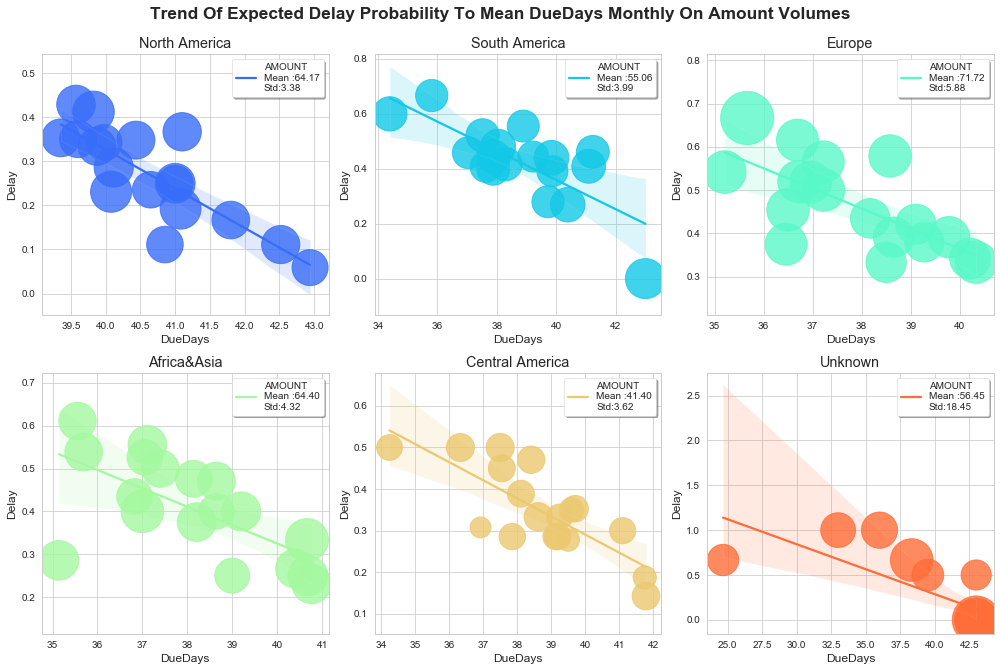

In [43]:
sns.set_palette('rainbow')
sns.set_style('whitegrid')
data = monthly['na']
f, axs = plt.subplots(2,3, figsize=(14,9), sharex=False, sharey=False)
axs = np.ravel(axs)
for k,ax in zip(monthly, axs):
    data = monthly[k]
    sizes = ((data.Amount / train.Amount.mean())**10)*100
    sizes = data.Amount**1.75
    sns.regplot('DueDays', 'Delay', data=data, scatter_kws=dict(sizes=sizes), ax=ax, truncate=True)
    ax.set_title(keysregion[k])
    ax.legend(['AMOUNT\nMean :{:1.2f}\nStd:{:1.2f}'.format(data.Amount.mean(), data.Amount.std())], fancybox=True, shadow=True)
plt.tight_layout()
plt.suptitle("Trend Of Expected Delay Probability To Mean DueDays Monthly On Amount Volumes", y=1.03, fontsize='xx-large', fontweight='bold');

- There is a clear negative correlation between occuring delay and the number of due days for all regions.
- This relationship seems more important than the relationship of amount level and delay.

# Visualization, Modeling, Machine Learning

Can you build a model that can predict whether an invoice will have payment delayed or not and how different features influence the outcome? Please explain your findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model would be evaluated on the basis F1-Score.**
- **Read the test.csv file and prepare features for testing.**

#### 1. Load Test Set

In [44]:
test = pd.read_csv("test.csv", index_col=0)
test.head()

,Region,OrderDate,InvoiceDate,DueDate,Amount,Disputed,InvoiceType
UniqueId,,,,,,,
5420077969,South America,2013-03-15,2013-06-05,2013-07-18,34.360,No,Electronic
1020758229,Europe,2013-04-11,2013-06-06,2013-07-19,67.190,No,Electronic
6687811896,South America,2013-03-27,2013-06-06,2013-06-29,63.740,No,Electronic
8365605418,Europe,2013-04-27,2013-06-06,2013-07-19,65.160,No,Electronic
8019405718,North America,2013-04-08,2013-06-06,2013-07-13,47.990,Yes,Paper


#### 2. Treat Outliers in Test Set  

In [45]:
#1. Region
test.Region.value_counts()

North America      157
Europe             137
South America      128
Central America    102
Africa&Asia         84
Central umerica      1
Name: Region, dtype: int64

In [46]:
test.replace('Central umerica', 'Central America', inplace=True)
test.Region.unique()

array(['South America', 'Europe', 'North America', 'Central America',
       'Africa&Asia', nan], dtype=object)

In [47]:
#2. Dates
print(assert_dates(test.OrderDate))
test.OrderDate.sort_values()

There are 0 invalid dates.


UniqueId
3362601597    1913-08-24
5420077969    2013-03-15
6687811896    2013-03-27
8447618970    2013-03-29
8099966017    2013-03-30
                 ...    
3523951475    2013-11-06
1319645642    2013-11-07
7203564937    2013-11-08
299012002     2013-11-11
2455126326    2013-11-18
Name: OrderDate, Length: 616, dtype: object

In [48]:
# Treat invoice 3362601597 
test.loc[3362601597, 'OrderDate'] =  '2013-08-24' # infer correct year

In [49]:
print(assert_dates(test.InvoiceDate))
test.InvoiceDate.sort_values()

There are 0 invalid dates.


UniqueId
5420077969    2013-06-05
1020758229    2013-06-06
6687811896    2013-06-06
8365605418    2013-06-06
8019405718    2013-06-06
                 ...    
9835528694    2013-12-02
2455126326    2013-12-02
2189582262    2013-12-02
9366628825    2013-12-02
8249581875    2013-12-02
Name: InvoiceDate, Length: 616, dtype: object

In [50]:
print(assert_dates(test.DueDate))
test.DueDate.sort_values()

There are 0 invalid dates.


UniqueId
6687811896    2013-06-29
8447618970    2013-06-30
1731769135    2013-07-02
4062781273    2013-07-10
9784423697    2013-07-11
                 ...    
6440354171    2014-01-13
2189582262    2014-01-14
9366628825    2014-01-14
9835528694    2014-01-14
8249581875    2014-01-14
Name: DueDate, Length: 616, dtype: object

In [51]:
# 3. Amount
test.Amount.describe()

count   609.000
mean     59.757
std      20.276
min       7.390
25%      46.400
50%      60.620
75%      73.080
max     116.660
Name: Amount, dtype: float64

In [52]:
# 4.Disputed
test.Disputed.value_counts()

No     473
Yes    139
Name: Disputed, dtype: int64

#### 4. Treat Missing Values In Test Set

In [53]:
test.isna().sum()

Region         7
OrderDate      0
InvoiceDate    0
DueDate        0
Amount         7
Disputed       4
InvoiceType    7
dtype: int64

In [54]:
test.Amount.fillna(train.Amount.mean(), inplace=True)
test.replace(np.nan, 'Unknown', inplace=True)
print('NaN in Test Set:', test.isna().sum().sum())

NaN in Test Set: 0


#### 5. Transform Data Types In Test Set

In [55]:
test[tsvars] = test[tsvars].apply(pd.to_datetime)
test[ctgs] = test[ctgs].astype('category')
test.dtypes

Region               category
OrderDate      datetime64[ns]
InvoiceDate    datetime64[ns]
DueDate        datetime64[ns]
Amount                float64
Disputed             category
InvoiceType          category
dtype: object

#### 6. Feature Extraction - Feature Generation  - Base Model - Feature Selection

In [56]:
pd.qcut(train.Amount,5).unique()

[(43.062, 55.998], (65.256, 76.808], (76.808, 128.28], (5.2589999999999995, 43.062], (55.998, 65.256]]
Categories (5, interval[float64]): [(5.2589999999999995, 43.062] < (43.062, 55.998] < (55.998, 65.256] < (65.256, 76.808] < (76.808, 128.28]]

In [57]:
def get_amount_quantile(amount):
    """5 Quantiles of train dataset for amount"""
    if amount<=43.062: return 1
    elif amount<=55.99: return 2
    elif amount<=65.26: return 3
    elif amount<=76.81: return 4
    else:return 5

*Feature Extraction*

In [101]:
# Data Unification for feature extraction
X = train.drop('Delay', axis=1).append(test)
y_train = train.Delay.copy()

# Add TimeDelta Features
X['OrderInvoiceDelta'] = np.int64(pd.to_numeric(X.InvoiceDate - X.OrderDate)*1e-10)
X['OrderDueDelta'] = np.int64(pd.to_numeric(X.DueDate - X.OrderDate)*1e-10)
X['DueInvoiceDelta'] = np.int64(pd.to_numeric(X.DueDate - X.InvoiceDate)*1e-10)
X['DueOrderDelta'] = np.int64(pd.to_numeric(X.DueDate - X.OrderDate)*1e-10)

# Add OrderDate Time Features
X['OrderYear'] = X.OrderDate.apply(lambda dt:dt.year)
X['OrderMonth'] = X.OrderDate.apply(lambda dt:dt.month)
X['OrderWeek'] = X.OrderDate.apply(lambda dt: dt.week)

# Add Serialized Month Feature
months_nums = X.OrderMonth  + (X.OrderYear - X.OrderYear.min())*12
X['OrderMonthSerialized'] = months_nums - months_nums.min() + 1
weeks_nums = X.OrderWeek  + (X.OrderYear - X.OrderYear.min())*52
X['OrderWeekSerialized'] = weeks_nums - weeks_nums.min() + 1

# Categorize Amount
X['AmountCtg'] = X.Amount.apply(get_amount_quantile)

# Add Interaction Category
X ['Interactions'] = X.apply(lambda row:"{}_{}_{}".format(row.Region, row.AmountCtg, row.InvoiceType), axis=1)

# Finalize Feature Extraction
X.drop(['InvoiceDate', 'DueDate', 'OrderDate'], axis=1, inplace=True)
X_train, X_test = X.loc[train.index], X.loc[test.index]

*Feature Generation*

In [102]:
# Add Different Encoding to Categories and to Amount
encode_cols = ["Region","Amount","Disputed","InvoiceType"]
CountEncoder = CtgEncoders.CountEncoder(cols=encode_cols)
TargetEncoder = CtgEncoders.TargetEncoder(cols=encode_cols)
CatBoostEncoder = CtgEncoders.CatBoostEncoder(cols=encode_cols)

ce_feats = CountEncoder.fit_transform(X_train[encode_cols], y_train)
te_feats = TargetEncoder.fit_transform(X_train[encode_cols], y_train)
cbe_feats = CatBoostEncoder.fit_transform(X_train[encode_cols], y_train)

ce_feats.columns = [name+"_ce" for name in ce_feats]
te_feats.columns = [name+"_te" for name in te_feats]
cbe_feats.columns = [name+"_cbe" for name in cbe_feats]

#Finalize modeling features
X_train_md = X_train.join([ce_feats, te_feats, cbe_feats], sort=True)
X_train_md = pd.get_dummies(X_train_md, columns=['Region', 'Disputed', 'InvoiceType', 'Interactions'])

**Report**
- The feature extraction and feature generation process provided 14 new features for the model.
- After the OneHotEncoding of the new categorical variables the data provides 100 columns for the model.
- To solve the dimensionality curse, a feature selection on the base model will provide the most high coefficients.

*Scoring Function*

In [60]:
scoring = make_scorer(f1_score)

*Define Validation and Training Data*

In [103]:
valid_nmonths = int(X_train.OrderMonthSerialized.nunique() * 0.2)
valid_months = sorted(set(X_train.OrderMonthSerialized))[-valid_nmonths:]
valid_months

[17, 18, 19, 20]

In [104]:
x_valid = X_train_md[X_train_md.OrderMonthSerialized.isin(valid_months)]
x_train = X_train_md.drop(x_valid.index)
y_valid = y_train.loc[x_valid.index]
y_xtrain = y_train.loc[x_train.index]

---

In [63]:
def model_results(X_test, y_true, model):
    y_pred = model.predict(X_test)
    cnf = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return cnf, report, f1

def print_results(X_test, y_true, model):
    print("{}\n\n{}\n\nF1-Score:{:1.5f}".format(*model_results(X_test, y_true, model)))

*Base Model*

In [296]:
base_estimator = LogisticRegression(random_state=555, n_jobs=-1)
base_pg = dict(C=np.linspace(1e-6, 5, 10000), penalty=['l2','l1'])
base = RandomizedSearchCV(base_estimator, base_pg, cv=7, verbose=3, scoring=scoring, random_state=555, iid=False, n_iter=200)

In [65]:
base.fit(x_train, y_xtrain)

NameError: name 'base' is not defined

In [299]:
print('LogisticRegression Params:{}\tScore:{:1.3f}'.format(base.best_params_, base.best_score_))

LogisticRegression Params:{'penalty': 'l1', 'C': 4.566456732373237}	Score:0.934


In [300]:
base_estimator_fitted = base.best_estimator_
base_estimator_fitted

LogisticRegression(C=4.566456732373237, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l1',
                   random_state=555, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:
print_results(X_train_md[X_train_md.OrderMonthSerialized.isin(valid_months)], y_valid, base)

[[208   0]
 [ 13  79]]

              precision    recall  f1-score   support

       False       0.94      1.00      0.97       208
        True       1.00      0.86      0.92        92

    accuracy                           0.96       300
   macro avg       0.97      0.93      0.95       300
weighted avg       0.96      0.96      0.96       300


F1-Score:0.92398


*Feature Selection*

In [71]:
selector = SelectFromModel(base_estimator_fitted, prefit=True)

In [72]:
keep_feats = pd.DataFrame(selector.get_support(), index=x_train.columns, columns=['IsKept'])

In [73]:
feat_selection = keep_feats[keep_feats.IsKept==True].index
print("Feature Selection: {1} -> {0}".format(len(feat_selection), x_train.shape[1]))

Feature Selection: 101 -> 52


*Finalize Modeling Features*

In [74]:
x_train = x_train[feat_selection]
x_valid = x_valid[feat_selection]

In [75]:
scaler = StandardScaler()
x_train_su = scaler.fit_transform(x_train)
x_valid_su = scaler.transform(x_valid)

In [76]:
x_train.shape, x_valid.shape, y_xtrain.shape, y_valid.shape

((1547, 52), (300, 52), (1547,), (300,))

*Model_1 - SupportVectorMachines Classifier*

In [327]:
clf1_estimator = SVC(cache_size=1000, random_state=555, gamma='scale', kernel='linear')
clf1_pg = dict(C=np.linspace(5, 100, 100)) # 100 -> choose (5,100,30) for accelerating training            
clf1 = GridSearchCV(clf1_estimator, clf1_pg, cv=7, scoring=scoring, verbose=3, iid=False, n_jobs=-1)

In [328]:
clf1.fit(x_train_su, y_xtrain);

Fitting 7 folds for each of 100 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed: 12.6min finished


In [329]:
print("SVC Score:{:1.5f}\nParams:{}".format(clf1.best_score_, clf1.best_params_))

SVC Score:0.95251
Params:{'C': 33.78787878787878}


In [378]:
print_results(x_valid_su, y_valid, clf1)

[[208   0]
 [ 11  81]]

              precision    recall  f1-score   support

       False       0.95      1.00      0.97       208
        True       1.00      0.88      0.94        92

    accuracy                           0.96       300
   macro avg       0.97      0.94      0.96       300
weighted avg       0.97      0.96      0.96       300


F1-Score:0.93642


*Model_2 - QuadraticDiscriminantAnalysis*

In [331]:
clf2_estimator = QuadraticDiscriminantAnalysis()
clf2_pg = dict(reg_param=np.linspace(0, 1, 100))
clf2 = GridSearchCV(clf2_estimator, clf2_pg, scoring=scoring, iid=False, verbose=3, cv=7, n_jobs=-1)

In [336]:
clf2.fit(x_train, y_xtrain);

Fitting 7 folds for each of 100 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.4s finished


In [337]:
print("QDA Score:{:1.3f}\nParams:{}".format(clf2.best_score_, clf2.best_params_))

QDA Score:0.898
Params:{'reg_param': 0.98989898989899}


In [379]:
print_results(x_valid, y_valid, clf2)

[[188  20]
 [  7  85]]

              precision    recall  f1-score   support

       False       0.96      0.90      0.93       208
        True       0.81      0.92      0.86        92

    accuracy                           0.91       300
   macro avg       0.89      0.91      0.90       300
weighted avg       0.92      0.91      0.91       300


F1-Score:0.86294


*Model_3 - LightGBM*

In [339]:
clf3_estimator = LGBMClassifier(random_state=555, num_leaves=100, subsample_for_bin=500000, )
clf3_pg = dict(learning_rate = [0.0001, 0.001, 0.01, 0.1, 1],
               n_estimators=[50, 100, 500],
               reg_alpha=[0, 0.1, 0.25, 0.50, 0.75, 1],
               reg_lambda=[0, 0.1, 0.25, 0.50, 0.75, 1])
clf3 = GridSearchCV(clf3_estimator, clf3_pg, scoring=scoring, iid=False, verbose=3, cv=7, n_jobs=-1)

In [348]:
clf3.fit(x_train, y_xtrain);

Fitting 7 folds for each of 540 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 2156 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 2685 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 3386 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed:   59.9s finished


In [349]:
print("LGBM Score:{:1.5f}\nParams:{}".format(clf3.best_score_, clf3.best_params_))

LGBM Score:0.97294
Params:{'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 1}


In [380]:
print_results(x_valid, y_valid, clf3)

[[208   0]
 [  5  87]]

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       208
        True       1.00      0.95      0.97        92

    accuracy                           0.98       300
   macro avg       0.99      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300


F1-Score:0.97207


**Report**
- The modeling process found the non-linear LGBM classifier to provide a clearly better f1-score than the base model and also the Support Vector Machines classifier. The score difference of 0.97 of LGBM against the 0.93 of the SVM is adequate to be confident that the LGBM will perform better in unseen data since the model is optimized in the state-of-art validation method of K-fold cross-validation with k=7 and tested in unseen data.
- The base linear model provided a score of 0.96 which offers the opportunity to analyze linearly the features with confidence.

*Finalize Model*

In [77]:
X_train_md = X_train_md[feat_selection]
model = LGBMClassifier(**{'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 1})
model.fit(X_train_md, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.5, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

---

**Show management the most important features in your model.**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


In [78]:
featimp = pd.Series(model.feature_importances_, index=X_train_md.columns, name='importances').sort_values(ascending=False)

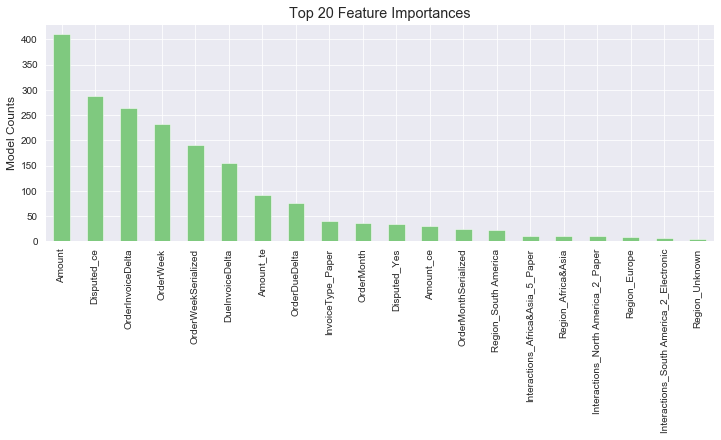

In [98]:
sns.set_palette('Accent')
sns.set_style("darkgrid")
featimp[:20].plot(kind='bar', figsize=(12,4), title='Top 20 Feature Importances')
plt.ylabel("Model Counts");

- The feature importances of the non-linear model underline the significance of the amounts, the disputed invoices and the time variables on the delay outcome of the invoice payment.  
- Region features and interactions seem to be the less significant features.
- Whether an invoice is paper or not seem to be in the top significant features.

---
- **Submit the predictions on the test dataset using your optimized model**

    For each record in the test set (`test.csv`), you must predict the `Delay` variable. You should submit a CSV file with a header row and one row per test entry.

The file (`submission.csv`) should have exactly 2 columns:
   - **UniqueId**
   - **Delay**

*Preprocess Test Set*

In [359]:
ce_feats_test = CountEncoder.transform(X_test[encode_cols])
te_feats_test = TargetEncoder.transform(X_test[encode_cols])
cbe_feats_test = CatBoostEncoder.transform(X_test[encode_cols])

ce_feats_test.columns = [name+"_ce" for name in ce_feats_test]
te_feats_test.columns = [name+"_te" for name in te_feats_test]
cbe_feats_test.columns = [name+"_cbe" for name in cbe_feats_test]

X_test_md = X_test.join([ce_feats_test, te_feats_test, cbe_feats_test], sort=True)
X_test_md = pd.get_dummies(X_test_md, columns=['Region', 'Disputed', 'InvoiceType', 'Interactions'])
for c in ['Interactions_Unknown_2_Paper', 'Interactions_South America_1_Paper', 'Interactions_South America_3_Paper']:
    X_test_md[c]= 0
x_test = X_test_md[feat_selection]

In [363]:
y_pred = model.predict(x_test) #predict

In [364]:
submission = pd.Series(y_pred, index=pd.Series(x_test.index, name='UniqueId'), name='Delay')

In [365]:
submission.to_csv("submission.csv", index=True, header=True)

#### Results On Actual Data

In [382]:
y_true = pd.read_csv("actual_output.csv", index_col=0, squeeze=True)
print_results(x_test, y_true, model)

[[440   0]
 [ 11 165]]

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       440
        True       1.00      0.94      0.97       176

    accuracy                           0.98       616
   macro avg       0.99      0.97      0.98       616
weighted avg       0.98      0.98      0.98       616


F1-Score:0.96774
